<a href="https://colab.research.google.com/github/lponcec94/PolyWorks/blob/main/semana_6/Semana_6_Local_Outlier_Factor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objetivo

El objetivo de este notebook es revisar el método de detección de valores extremos llamado Local Outlier Factor. Lo exploraremos a partir de implementarlo en dos datasets.

In [213]:
from io import StringIO, BytesIO
import urllib.request

from scipy.io import arff
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import LocalOutlierFactor

from warnings import simplefilter

simplefilter('ignore')
pd.options.display.float_format = '{:.3f}'.format


### Arrythmia

Este dataset contiene información sobre datos cardiacos de pasientes que han presentado arritmia por diferentes causas y pacientes que no la han presentado.

In [214]:
# Cargamos los datos desde github. 
url_arrythmia = 'https://raw.githubusercontent.com/Basvanstein/Gloss/master/datasets/uci-20070111-arrhythmia.arff'
resp_arrythmia = urllib.request.urlopen(url_arrythmia)

Los datasets se encuentran en un formato "arff" por lo que usaremos Scipy para poder leerlos y después transformalos a DF. 

In [215]:
data_arrythmia, meta_arrythmia = arff.loadarff(StringIO(resp_arrythmia.read().decode('utf-8')))

In [216]:
type(meta_arrythmia)

scipy.io.arff.arffread.MetaData

In [217]:
df_arryth = pd.DataFrame(data_arrythmia)

#### Exploramos los datos

In [218]:
df_arryth.head()

,age,sex,height,weight,QRSduration,PRinterval,Q-Tinterval,Tinterval,Pinterval,QRS,T,P,QRST,J,heartrate,chDI_Qwave,chDI_Rwave,chDI_Swave,chDI_RPwave,chDI_SPwave,chDI_intrinsicReflecttions,chDI_RRwaveExists,chDI_DD_RRwaveExists,chDI_RPwaveExists,chDI_DD_RPwaveExists,chDI_RTwaveExists,chDI_DD_RTwaveExists,chDII_Qwave,chDII_Rwave,chDII_Swave,chDII_RPwave,chDII_SPwave,chDII_intrinsicReflecttions,chDII_RRwaveExists,chDII_DD_RRwaveExists,chDII_RPwaveExists,chDII_DD_RPwaveExists,chDII_RTwaveExists,chDII_DD_RTwaveExists,chDIII_Qwave,...,chV3_QwaveAmp,chV3_RwaveAmp,chV3_SwaveAmp,chV3_RPwaveAmp,chV3_SPwaveAmp,chV3_PwaveAmp,chV3_TwaveAmp,chV3_QRSA,chV3_QRSTA,chV4_JJwaveAmp,chV4_QwaveAmp,chV4_RwaveAmp,chV4_SwaveAmp,chV4_RPwaveAmp,chV4_SPwaveAmp,chV4_PwaveAmp,chV4_TwaveAmp,chV4_QRSA,chV4_QRSTA,chV5_JJwaveAmp,chV5_QwaveAmp,chV5_RwaveAmp,chV5_SwaveAmp,chV5_RPwaveAmp,chV5_SPwaveAmp,chV5_PwaveAmp,chV5_TwaveAmp,chV5_QRSA,chV5_QRSTA,chV6_JJwaveAmp,chV6_QwaveAmp,chV6_RwaveAmp,chV6_SwaveAmp,chV6_RPwaveAmp,chV6_SPwaveAmp,chV6_PwaveAmp,chV6_TwaveAmp,chV6_QRSA,chV6_QRSTA,class
0,75.000,b'0',190.000,80.000,91.000,193.000,371.000,174.000,121.000,-16.000,13.000,64.000,-2.000,nan,63.000,0.000,52.000,44.000,0.000,0.000,32.000,b'0',b'0',b'0',b'0',b'0',b'0',0.000,44.000,20.000,36.000,0.000,28.000,b'0',b'0',b'0',b'0',b'0',b'0',52.000,...,0.000,8.400,-10.000,0.000,0.000,0.600,5.900,-3.900,52.700,-0.300,0.000,15.200,-8.400,0.000,0.000,0.900,5.100,17.700,70.700,-0.400,0.000,13.500,-4.000,0.000,0.000,0.900,3.900,25.500,62.900,-0.300,0.000,9.000,-0.900,0.000,0.000,0.900,2.900,23.300,49.400,b'8'
1,56.000,b'1',165.000,64.000,81.000,174.000,401.000,149.000,39.000,25.000,37.000,-17.000,31.000,nan,53.000,0.000,48.000,0.000,0.000,0.000,24.000,b'0',b'0',b'0',b'0',b'0',b'0',0.000,64.000,0.000,0.000,0.000,24.000,b'0',b'0',b'0',b'0',b'0',b'0',32.000,...,0.000,5.800,-7.700,0.000,0.000,0.900,3.800,-5.700,27.700,-0.200,0.000,9.500,-5.000,0.000,0.000,0.500,2.600,11.800,34.600,-0.400,0.000,11.000,-2.400,0.000,0.000,0.400,2.600,21.600,43.400,-0.500,0.000,8.500,0.000,0.000,0.000,0.200,2.100,20.400,38.800,b'6'
2,54.000,b'0',172.000,95.000,138.000,163.000,386.000,185.000,102.000,96.000,34.000,70.000,66.000,23.000,75.000,0.000,40.000,80.000,0.000,0.000,24.000,b'0',b'0',b'0',b'0',b'0',b'0',20.000,56.000,52.000,0.000,0.000,40.000,b'0',b'0',b'0',b'0',b'0',b'0',28.000,...,0.000,5.800,-4.100,4.000,-0.500,0.400,0.300,20.400,23.300,0.700,0.000,10.000,-5.700,0.000,0.000,0.500,2.200,-3.000,20.700,1.300,0.000,11.100,-3.400,0.000,0.000,0.400,3.400,11.500,48.200,0.900,0.000,9.500,-2.400,0.000,0.000,0.300,3.400,12.300,49.000,b'10'
3,55.000,b'0',175.000,94.000,100.000,202.000,380.000,179.000,143.000,28.000,11.000,-5.000,20.000,nan,71.000,0.000,72.000,20.000,0.000,0.000,48.000,b'0',b'0',b'0',b'0',b'0',b'0',0.000,64.000,36.000,0.000,0.000,36.000,b'0',b'0',b'0',b'0',b'0',b'0',20.000,...,0.000,9.000,-7.900,0.000,0.000,0.100,4.100,7.600,51.000,0.400,0.000,15.000,-5.500,0.000,0.000,0.100,3.300,28.800,63.100,0.100,0.000,15.200,-3.700,0.000,0.000,0.600,3.000,36.800,68.000,0.100,0.000,12.200,-2.200,0.000,0.000,0.400,2.600,34.600,61.600,b'1'
4,75.000,b'0',190.000,80.000,88.000,181.000,360.000,177.000,103.000,-16.000,13.000,61.000,3.000,nan,-2147483648.000,0.000,48.000,40.000,0.000,0.000,28.000,b'0',b'0',b'0',b'0',b'0',b'0',0.000,40.000,24.000,0.000,0.000,24.000,b'0',b'0',b'0',b'0',b'0',b'0',52.000,...,0.000,8.500,-10.200,0.000,0.000,-1.000,4.700,-4.000,43.000,-0.200,0.000,15.200,-7.800,0.000,0.000,-0.100,4.900,16.200,63.200,-0.200,0.000,9.100,-0.900,0.000,0.000,-0.200,2.900,21.700,48.900,-0.400,0.000,13.100,-3.600,0.000,0.000,-0.100,3.900,25.400,62.800,b'7'


In [219]:
df_arryth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, age to class
dtypes: float64(206), object(74)
memory usage: 988.9+ KB


In [220]:
df_arryth['age'].unique()

array([75., 56., 54., 55., 13., 40., 49., 44., 50., 62., 45., 30., 47.,
       46., 73., 57., 28., 36., 34., 31., 51., 53., 58., 52., 69., 35.,
       43., 41., 39., 24., 72., 38., 42., 32.,  1., 27., 48., 26., 64.,
       37., 71., 79., 63., 19., 68., 25., 33., 17.,  9., 29., 74., 61.,
       18., 60., 59., 66., 65., 22., 21., 70., 11., 77., 83., 67., 80.,
       15.,  7., 12., 14.,  0.,  3., 20., 81.,  8., 78., 16., 76.])

Tenemos columnas que no están en el tipo de dato correcto. Vamos a extraerlas y transformalas.

In [221]:
# Obtenemos las columnas con valores binarios. 
binary_col = list()
for col in df_arryth.columns:
  values = df_arryth[col].unique()
  if b'1' and b'0' in values:
    print(col, values)
    binary_col.append(col)

sex [b'0' b'1']
chDI_RRwaveExists [b'0' b'1']
chDI_DD_RRwaveExists [b'0' b'1']
chDI_RPwaveExists [b'0' b'1']
chDI_DD_RPwaveExists [b'0' b'1']
chDI_RTwaveExists [b'0' b'1']
chDI_DD_RTwaveExists [b'0' b'1']
chDII_RRwaveExists [b'0' b'1']
chDII_DD_RRwaveExists [b'0' b'1']
chDII_RPwaveExists [b'0' b'1']
chDII_DD_RPwaveExists [b'0' b'1']
chDII_RTwaveExists [b'0' b'1']
chDII_DD_RTwaveExists [b'0' b'1']
chDIII_RRwaveExists [b'0' b'1']
chDIII_DD_RRwaveExists [b'0' b'1']
chDIII_RPwaveExists [b'0' b'1']
chDIII_DD_RPwaveExists [b'0' b'1']
chDIII_RTwaveExists [b'0' b'1']
chDIII_DD_RTwaveExists [b'0' b'1']
chAVR_RRwaveExists [b'0' b'1']
chAVR_DD_RRwaveExists [b'0' b'1']
chAVR_RPwaveExists [b'0' b'1']
chAVR_DD_RPwaveExists [b'0' b'1']
chAVR_RTwaveExists [b'0' b'1']
chAVR_DD_RTwaveExists [b'0' b'1']
chAVL_RRwaveExists [b'0']
chAVL_DD_RRwaveExists [b'0' b'1']
chAVL_RPwaveExists [b'0' b'1']
chAVL_DD_RPwaveExists [b'0' b'1']
chAVL_RTwaveExists [b'0' b'1']
chAVL_DD_RTwaveExists [b'0' b'1']
chAVF_RRwaveEx

In [222]:
len(binary_col)

73

In [223]:
df_2 = df_arryth.copy() # Recordemos siempre trabajar sobre copias

In [224]:
for col in binary_col:
  df_2[col] = df_2[col].astype('int8')

In [225]:
df_2.head()

,age,sex,height,weight,QRSduration,PRinterval,Q-Tinterval,Tinterval,Pinterval,QRS,T,P,QRST,J,heartrate,chDI_Qwave,chDI_Rwave,chDI_Swave,chDI_RPwave,chDI_SPwave,chDI_intrinsicReflecttions,chDI_RRwaveExists,chDI_DD_RRwaveExists,chDI_RPwaveExists,chDI_DD_RPwaveExists,chDI_RTwaveExists,chDI_DD_RTwaveExists,chDII_Qwave,chDII_Rwave,chDII_Swave,chDII_RPwave,chDII_SPwave,chDII_intrinsicReflecttions,chDII_RRwaveExists,chDII_DD_RRwaveExists,chDII_RPwaveExists,chDII_DD_RPwaveExists,chDII_RTwaveExists,chDII_DD_RTwaveExists,chDIII_Qwave,...,chV3_QwaveAmp,chV3_RwaveAmp,chV3_SwaveAmp,chV3_RPwaveAmp,chV3_SPwaveAmp,chV3_PwaveAmp,chV3_TwaveAmp,chV3_QRSA,chV3_QRSTA,chV4_JJwaveAmp,chV4_QwaveAmp,chV4_RwaveAmp,chV4_SwaveAmp,chV4_RPwaveAmp,chV4_SPwaveAmp,chV4_PwaveAmp,chV4_TwaveAmp,chV4_QRSA,chV4_QRSTA,chV5_JJwaveAmp,chV5_QwaveAmp,chV5_RwaveAmp,chV5_SwaveAmp,chV5_RPwaveAmp,chV5_SPwaveAmp,chV5_PwaveAmp,chV5_TwaveAmp,chV5_QRSA,chV5_QRSTA,chV6_JJwaveAmp,chV6_QwaveAmp,chV6_RwaveAmp,chV6_SwaveAmp,chV6_RPwaveAmp,chV6_SPwaveAmp,chV6_PwaveAmp,chV6_TwaveAmp,chV6_QRSA,chV6_QRSTA,class
0,75.000,0,190.000,80.000,91.000,193.000,371.000,174.000,121.000,-16.000,13.000,64.000,-2.000,nan,63.000,0.000,52.000,44.000,0.000,0.000,32.000,0,0,0,0,0,0,0.000,44.000,20.000,36.000,0.000,28.000,0,0,0,0,0,0,52.000,...,0.000,8.400,-10.000,0.000,0.000,0.600,5.900,-3.900,52.700,-0.300,0.000,15.200,-8.400,0.000,0.000,0.900,5.100,17.700,70.700,-0.400,0.000,13.500,-4.000,0.000,0.000,0.900,3.900,25.500,62.900,-0.300,0.000,9.000,-0.900,0.000,0.000,0.900,2.900,23.300,49.400,b'8'
1,56.000,1,165.000,64.000,81.000,174.000,401.000,149.000,39.000,25.000,37.000,-17.000,31.000,nan,53.000,0.000,48.000,0.000,0.000,0.000,24.000,0,0,0,0,0,0,0.000,64.000,0.000,0.000,0.000,24.000,0,0,0,0,0,0,32.000,...,0.000,5.800,-7.700,0.000,0.000,0.900,3.800,-5.700,27.700,-0.200,0.000,9.500,-5.000,0.000,0.000,0.500,2.600,11.800,34.600,-0.400,0.000,11.000,-2.400,0.000,0.000,0.400,2.600,21.600,43.400,-0.500,0.000,8.500,0.000,0.000,0.000,0.200,2.100,20.400,38.800,b'6'
2,54.000,0,172.000,95.000,138.000,163.000,386.000,185.000,102.000,96.000,34.000,70.000,66.000,23.000,75.000,0.000,40.000,80.000,0.000,0.000,24.000,0,0,0,0,0,0,20.000,56.000,52.000,0.000,0.000,40.000,0,0,0,0,0,0,28.000,...,0.000,5.800,-4.100,4.000,-0.500,0.400,0.300,20.400,23.300,0.700,0.000,10.000,-5.700,0.000,0.000,0.500,2.200,-3.000,20.700,1.300,0.000,11.100,-3.400,0.000,0.000,0.400,3.400,11.500,48.200,0.900,0.000,9.500,-2.400,0.000,0.000,0.300,3.400,12.300,49.000,b'10'
3,55.000,0,175.000,94.000,100.000,202.000,380.000,179.000,143.000,28.000,11.000,-5.000,20.000,nan,71.000,0.000,72.000,20.000,0.000,0.000,48.000,0,0,0,0,0,0,0.000,64.000,36.000,0.000,0.000,36.000,0,0,0,0,0,0,20.000,...,0.000,9.000,-7.900,0.000,0.000,0.100,4.100,7.600,51.000,0.400,0.000,15.000,-5.500,0.000,0.000,0.100,3.300,28.800,63.100,0.100,0.000,15.200,-3.700,0.000,0.000,0.600,3.000,36.800,68.000,0.100,0.000,12.200,-2.200,0.000,0.000,0.400,2.600,34.600,61.600,b'1'
4,75.000,0,190.000,80.000,88.000,181.000,360.000,177.000,103.000,-16.000,13.000,61.000,3.000,nan,-2147483648.000,0.000,48.000,40.000,0.000,0.000,28.000,0,0,0,0,0,0,0.000,40.000,24.000,0.000,0.000,24.000,0,0,0,0,0,0,52.000,...,0.000,8.500,-10.200,0.000,0.000,-1.000,4.700,-4.000,43.000,-0.200,0.000,15.200,-7.800,0.000,0.000,-0.100,4.900,16.200,63.200,-0.200,0.000,9.100,-0.900,0.000,0.000,-0.200,2.900,21.700,48.900,-0.400,0.000,13.100,-3.600,0.000,0.000,-0.100,3.900,25.400,62.800,b'7'


In [226]:
# La variable target tiene más de dos clases, vamos a revisarla
df_2['class'] = df_2['class'].astype('int8')

In [227]:
df_2['class'].sort_values(ascending=True).unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16], dtype=int8)

In [228]:
df_2['class'] = df_2['class'].apply(lambda x: 0 if x == 1 else 1)

In [229]:
# Revisamos las columnas con valores nulos
null_col = df_2.isnull().mean()
null_col

age             0.000
sex             0.000
height          0.000
weight          0.000
QRSduration     0.000
                 ... 
chV6_PwaveAmp   0.000
chV6_TwaveAmp   0.000
chV6_QRSA       0.000
chV6_QRSTA      0.000
class           0.000
Length: 280, dtype: float64

In [230]:
null_col = df_2.isnull().mean()
null_col = null_col[null_col != 0.0]
null_col

J   0.832
dtype: float64

In [231]:
df_2.drop(columns='J', inplace=True)

#### Recursive Feature Elimination

In [232]:
X = df_2.drop(columns='class')
y = df_2['class']

In [233]:
model = BernoulliNB(alpha=0)
rfe = RFE(model, 15)
rfe.fit(X, y)

RFE(estimator=BernoulliNB(alpha=0, binarize=0.0, class_prior=None,
                          fit_prior=True),
    n_features_to_select=15, step=1, verbose=0)

In [234]:
print("Num Features: %d" % rfe.n_features_)

Num Features: 15


In [235]:
print("Selected Features: %s" % rfe.support_)

Selected Features: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False F

In [236]:
print("Feature Ranking: %s" % rfe.ranking_)

Feature Ranking: [259 159 264 263 262 234 261 260 236 184 191 205 192 255 147 249 170  92
  43 253  55  69  68  67  66  93 145 258 171 105  65 256 100 124  54  53
  52 109 158 221 161 126  51 226  42 121  41  57  85  71 201 182 139 128
  40 183  48  77  46  61  72  99 152 239 164 108  39 237  38 111  37  50
  47  45 151 241 165 117  90 238  63 113  36  35  34  59 146 196 189 140
  73 195  86 114  74  91  76 107 135 210 206 132  88 209  79  98 101  97
  96 112 130 222 216 110  78 224 119  70  82  94  83 106 134 245 235 120
  60 244  62  95  33  32  64 115 148 247 220  87  31 248  30  89  29  28
  27  75 155 250 180  49  26 252  25  58  44  24  23  80 144  22 251  21
  81  20 232 185 214 228 153  19 257  18 104  17 218 198 213 225 160  16
 227  15 127  14 202 174 168 169 173  13 181  12 129  11 123 143 125 122
 149  10 240   9 103   8 163 166 176 175 157   7 242   6 118   5 212 197
 187 193 208   4 194   3 138   2 150 167 133 141 199   1 211   1 131   1
 162 207 136 172 179   1 223   1 1

In [237]:
selected_columns = [col for col, val in zip(X.columns, rfe.support_) if val]
selected_columns

['chV2_QwaveAmp',
 'chV2_SwaveAmp',
 'chV2_SPwaveAmp',
 'chV3_QwaveAmp',
 'chV3_SwaveAmp',
 'chV3_SPwaveAmp',
 'chV4_QwaveAmp',
 'chV4_SwaveAmp',
 'chV4_SPwaveAmp',
 'chV5_QwaveAmp',
 'chV5_SwaveAmp',
 'chV5_SPwaveAmp',
 'chV6_QwaveAmp',
 'chV6_SwaveAmp',
 'chV6_SPwaveAmp']

Filtramos las columnas que eligió RFE.

In [238]:
df_filter = df_2[selected_columns].copy()

In [239]:
df_filter['class'] = y

In [240]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   chV2_QwaveAmp   452 non-null    float64
 1   chV2_SwaveAmp   452 non-null    float64
 2   chV2_SPwaveAmp  452 non-null    float64
 3   chV3_QwaveAmp   452 non-null    float64
 4   chV3_SwaveAmp   452 non-null    float64
 5   chV3_SPwaveAmp  452 non-null    float64
 6   chV4_QwaveAmp   452 non-null    float64
 7   chV4_SwaveAmp   452 non-null    float64
 8   chV4_SPwaveAmp  452 non-null    float64
 9   chV5_QwaveAmp   452 non-null    float64
 10  chV5_SwaveAmp   452 non-null    float64
 11  chV5_SPwaveAmp  452 non-null    float64
 12  chV6_QwaveAmp   452 non-null    float64
 13  chV6_SwaveAmp   452 non-null    float64
 14  chV6_SPwaveAmp  452 non-null    float64
 15  class           452 non-null    int64  
dtypes: float64(15), int64(1)
memory usage: 56.6 KB


In [241]:
df_filter.head()

,chV2_QwaveAmp,chV2_SwaveAmp,chV2_SPwaveAmp,chV3_QwaveAmp,chV3_SwaveAmp,chV3_SPwaveAmp,chV4_QwaveAmp,chV4_SwaveAmp,chV4_SPwaveAmp,chV5_QwaveAmp,chV5_SwaveAmp,chV5_SPwaveAmp,chV6_QwaveAmp,chV6_SwaveAmp,chV6_SPwaveAmp,class
0,0.000,-6.400,0.000,0.000,-10.000,0.000,0.000,-8.400,0.000,0.000,-4.000,0.000,0.000,-0.900,0.000,1
1,0.000,-7.900,0.000,0.000,-7.700,0.000,0.000,-5.000,0.000,0.000,-2.400,0.000,0.000,0.000,0.000,1
2,0.000,-4.100,0.000,0.000,-4.100,-0.500,0.000,-5.700,0.000,0.000,-3.400,0.000,0.000,-2.400,0.000,1
3,0.000,-6.900,0.000,0.000,-7.900,0.000,0.000,-5.500,0.000,0.000,-3.700,0.000,0.000,-2.200,0.000,0
4,0.000,-6.000,0.000,0.000,-10.200,0.000,0.000,-7.800,0.000,0.000,-0.900,0.000,0.000,-3.600,0.000,1


In [242]:
df_2[df_2['class'] == 1].shape, df_filter[df_filter['class'] == 0].shape

((207, 279), (245, 16))

In [243]:
df_filter.describe()

,chV2_QwaveAmp,chV2_SwaveAmp,chV2_SPwaveAmp,chV3_QwaveAmp,chV3_SwaveAmp,chV3_SPwaveAmp,chV4_QwaveAmp,chV4_SwaveAmp,chV4_SPwaveAmp,chV5_QwaveAmp,chV5_SwaveAmp,chV5_SPwaveAmp,chV6_QwaveAmp,chV6_SwaveAmp,chV6_SPwaveAmp,class
count,452.000,452.000,452.000,452.000,452.000,452.000,452.000,452.000,452.000,452.000,452.000,452.000,452.000,452.000,452.000,452.000
mean,-0.914,-9.049,-0.016,-0.654,-10.151,-0.013,-0.298,-7.035,-0.003,-0.277,-3.608,0.000,-0.279,-1.457,0.000,0.458
std,3.764,5.890,0.218,3.414,7.067,0.264,1.759,5.061,0.046,0.992,2.851,0.000,0.549,2.002,0.000,0.499
min,-30.300,-43.300,-4.000,-32.900,-48.400,-5.600,-20.400,-42.900,-0.900,-14.200,-30.800,0.000,-4.100,-28.600,0.000,0.000
25%,0.000,-11.925,0.000,0.000,-13.000,0.000,0.000,-9.100,0.000,0.000,-4.725,0.000,-0.425,-2.100,0.000,0.000
50%,0.000,-8.300,0.000,0.000,-8.800,0.000,0.000,-6.000,0.000,0.000,-3.000,0.000,0.000,-1.100,0.000,0.000
75%,0.000,-5.600,0.000,0.000,-5.800,0.000,0.000,-3.700,0.000,0.000,-1.900,0.000,0.000,0.000,0.000,1.000
max,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


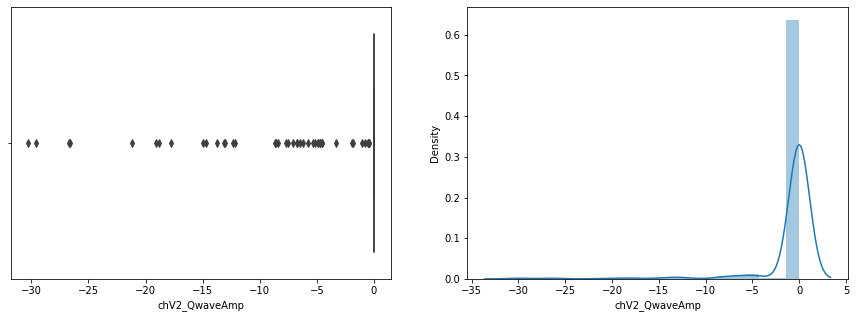

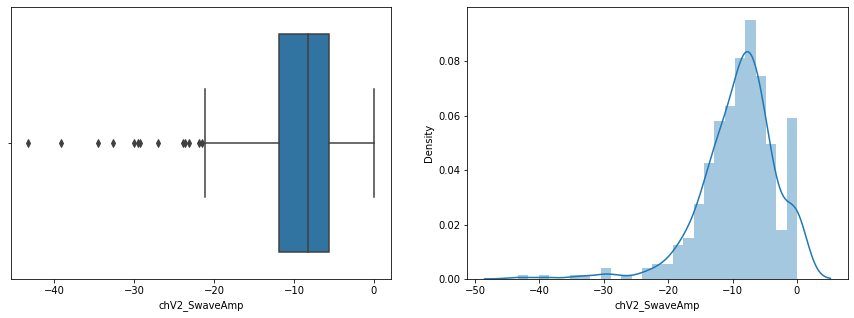

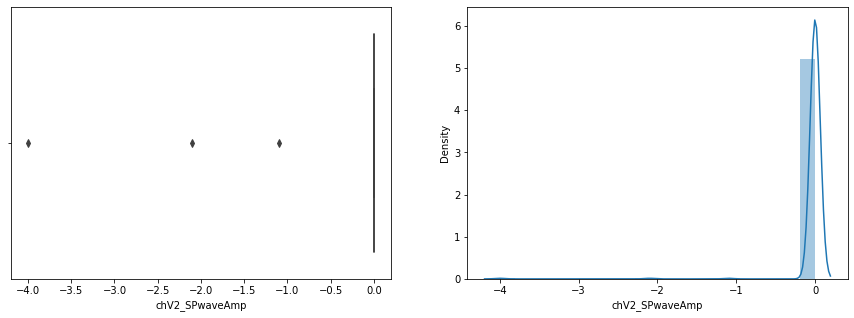

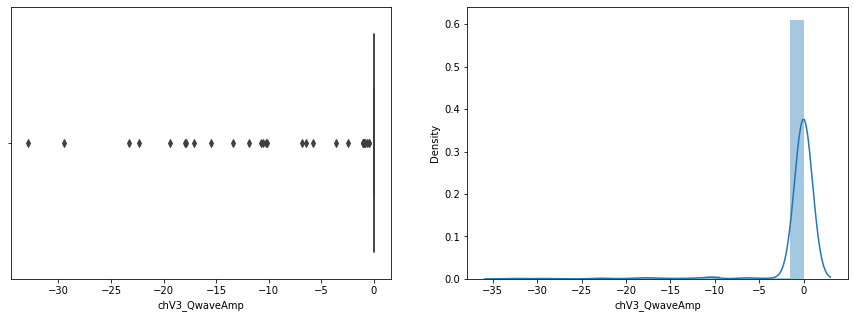

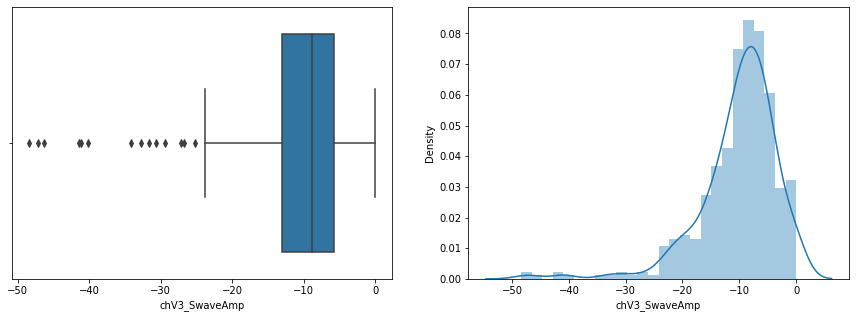

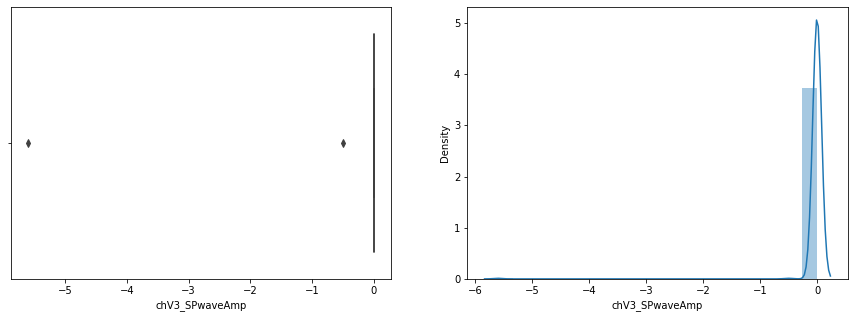

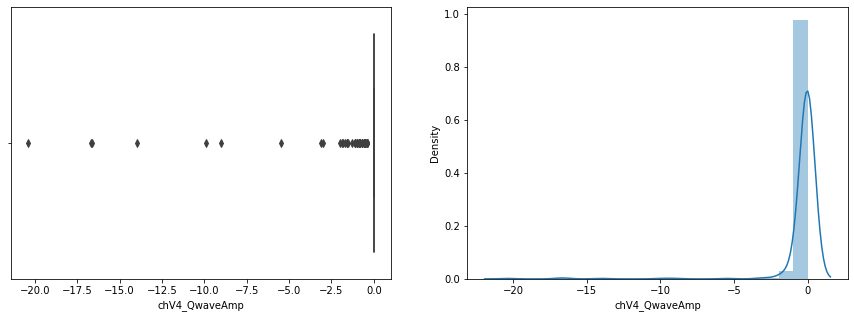

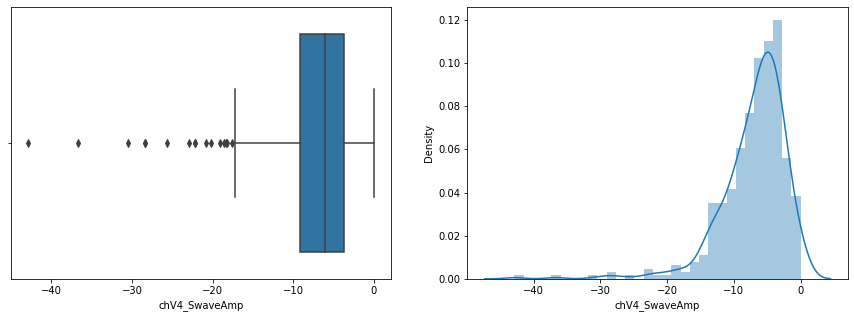

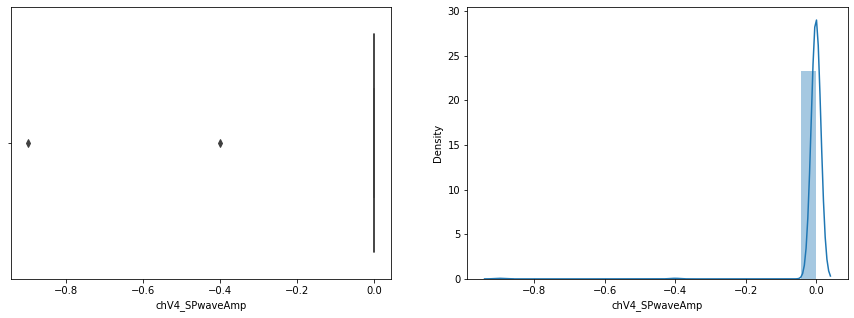

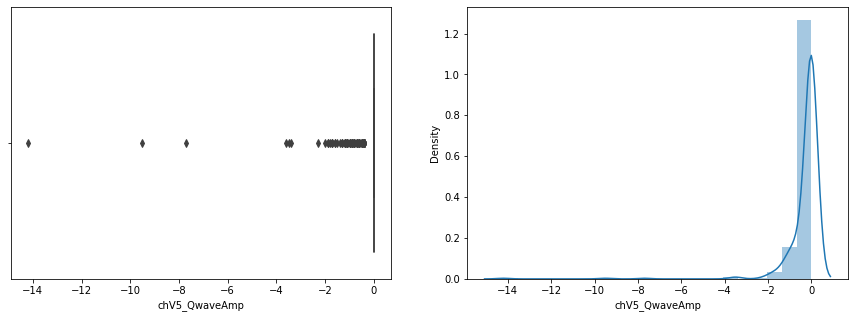

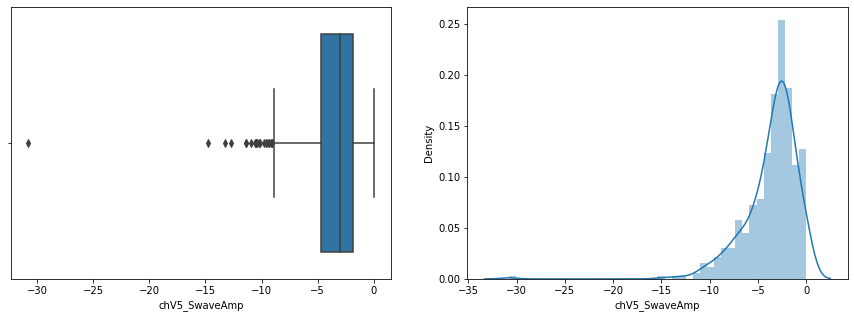

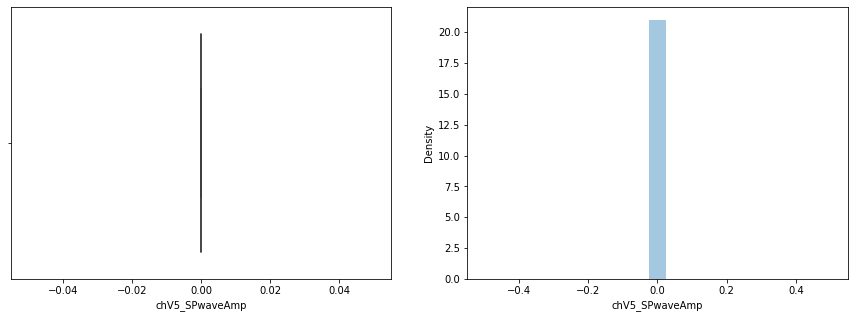

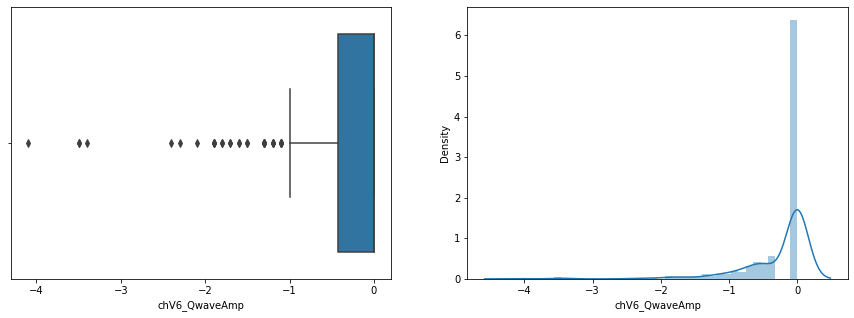

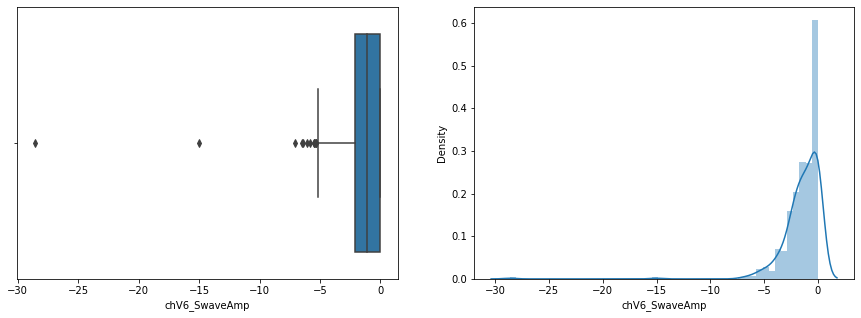

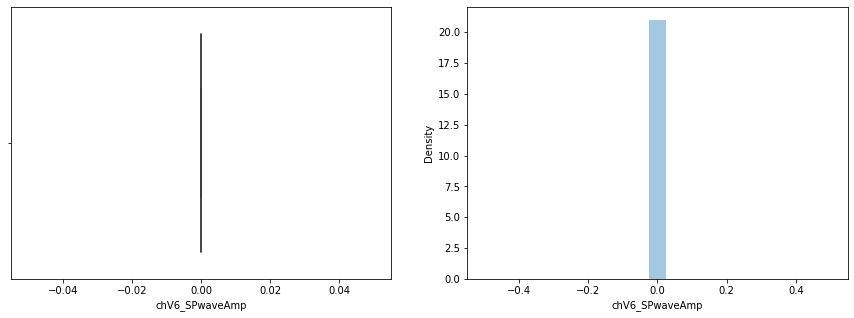

In [244]:
for col in df_filter.columns[:-1]:
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  sns.boxplot(x=df_filter[col], ax=ax[0])
  sns.distplot(a=df_filter[col], ax=ax[1])
  plt.show();

#### LOF en relación a un modelo

In [245]:
X = df_filter.iloc[:, :-1]
y = df_filter['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=42)

In [246]:
X_train.shape, X_test.shape

((406, 15), (46, 15))

In [247]:
model = BernoulliNB()
model.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [248]:
model.score(X_train, y_train)

0.5541871921182266

In [249]:
model.score(X_test, y_test)

0.43478260869565216

In [250]:
lof = LocalOutlierFactor()

In [251]:
y_pred = lof.fit_predict(X_train)
y_pred[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [252]:
y_pred.shape

(406,)

In [253]:
mask = y_pred == -1
mask[:20]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [254]:
mask[mask==True].shape

(55,)

In [255]:
X_train_outlier, y_train_outlier = X_train[mask], y_train[mask]

In [256]:
X_train_outlier.head()

,chV2_QwaveAmp,chV2_SwaveAmp,chV2_SPwaveAmp,chV3_QwaveAmp,chV3_SwaveAmp,chV3_SPwaveAmp,chV4_QwaveAmp,chV4_SwaveAmp,chV4_SPwaveAmp,chV5_QwaveAmp,chV5_SwaveAmp,chV5_SPwaveAmp,chV6_QwaveAmp,chV6_SwaveAmp,chV6_SPwaveAmp
297,0.000,0.000,0.000,0.000,-0.400,0.000,0.000,-3.300,0.000,0.000,-2.500,0.000,-0.600,-1.200,0.000
433,-4.500,0.000,0.000,-10.700,0.000,0.000,0.000,-8.800,0.000,0.000,-6.500,0.000,0.000,-5.400,0.000
116,0.000,-18.400,0.000,0.000,-29.400,0.000,0.000,-20.200,0.000,0.000,-9.800,0.000,-0.500,0.000,0.000
17,-6.700,0.000,0.000,0.000,-4.100,0.000,0.000,-2.900,0.000,0.000,-1.800,0.000,0.000,0.000,0.000
356,-4.900,0.000,0.000,-10.500,0.000,0.000,0.000,-13.300,0.000,0.000,-9.300,0.000,0.000,-3.400,0.000


In [257]:
X_train_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 297 to 102
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   chV2_QwaveAmp   55 non-null     float64
 1   chV2_SwaveAmp   55 non-null     float64
 2   chV2_SPwaveAmp  55 non-null     float64
 3   chV3_QwaveAmp   55 non-null     float64
 4   chV3_SwaveAmp   55 non-null     float64
 5   chV3_SPwaveAmp  55 non-null     float64
 6   chV4_QwaveAmp   55 non-null     float64
 7   chV4_SwaveAmp   55 non-null     float64
 8   chV4_SPwaveAmp  55 non-null     float64
 9   chV5_QwaveAmp   55 non-null     float64
 10  chV5_SwaveAmp   55 non-null     float64
 11  chV5_SPwaveAmp  55 non-null     float64
 12  chV6_QwaveAmp   55 non-null     float64
 13  chV6_SwaveAmp   55 non-null     float64
 14  chV6_SPwaveAmp  55 non-null     float64
dtypes: float64(15)
memory usage: 6.9 KB


In [258]:
mask = y_pred != -1 

X_train_clean, y_train_clean = X_train[mask], y_train[mask]

X_train_clean.shape, y_train_clean.shape

((351, 15), (351,))

In [259]:
model = BernoulliNB()
model.fit(X_train_clean, y_train_clean)

print('Train Accurracy Score', model.score(X_train_clean, y_train_clean))
print('Test Accurracy Score', model.score(X_test, y_test))

Train Accurracy Score 0.603988603988604
Test Accurracy Score 0.43478260869565216


Modificamos algunos parametros de nuestro algoritmo.

In [174]:
lof = LocalOutlierFactor(n_neighbors=30, p=1) # Manhattan
y_pred = lof.fit_predict(X_train, y_train)

In [175]:
mask = y_pred != -1 

X_train_clean, y_train_clean = X_train[mask], y_train[mask]
X_train_clean.shape, y_train_clean.shape

((343, 15), (343,))

In [177]:
model = BernoulliNB()
model.fit(X_train_clean, y_train_clean)

print('Train Accurracy Score', model.score(X_train_clean, y_train_clean))
print('Test Accurracy Score', model.score(X_test, y_test))

Train Accurracy Score 0.6151603498542274
Test Accurracy Score 0.43478260869565216


### Glass

Este dataset contiene información sobre datos de vidrios rotos encontrados en la escena del crimen. 

In [125]:
url_glass = 'https://raw.githubusercontent.com/Basvanstein/Gloss/master/datasets/uci-20070111-glass.arff'
resp_glass = urllib.request.urlopen(url_glass)

In [127]:
data_glass, meta_glass = arff.loadarff(StringIO(resp_glass.read().decode('utf-8')))

In [178]:
df_glass = pd.DataFrame(data_glass)

In [179]:
df_glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.518,12.790,3.500,1.120,73.030,0.000,8.770,0.000,0.000,b'build wind float'
1,1.516,12.160,3.520,1.350,72.890,0.000,8.530,0.000,0.000,b'vehic wind float'
2,1.518,13.210,3.480,1.410,72.640,0.000,8.430,0.000,0.000,b'build wind float'
3,1.513,14.400,1.740,1.540,74.550,0.000,7.590,0.000,0.000,b'tableware'
4,1.534,12.300,0.000,1.000,70.160,0.000,16.190,0.000,0.000,b'build wind non-float'


In [180]:
df_glass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    object 
dtypes: float64(9), object(1)
memory usage: 16.8+ KB


In [181]:
df_glass['Type'].unique()

array([b'build wind float', b'vehic wind float', b'tableware',
       b'build wind non-float', b'headlamps', b'containers'], dtype=object)

In [182]:
# Codificamos nuestra variable target
encoder = LabelEncoder()
encoder.fit(df_glass[['Type']])

df_glass['Type_enc'] =  encoder.fit_transform(df_glass[['Type']])

In [183]:
df_glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type,Type_enc
0,1.518,12.790,3.500,1.120,73.030,0.000,8.770,0.000,0.000,b'build wind float',0
1,1.516,12.160,3.520,1.350,72.890,0.000,8.530,0.000,0.000,b'vehic wind float',5
2,1.518,13.210,3.480,1.410,72.640,0.000,8.430,0.000,0.000,b'build wind float',0
3,1.513,14.400,1.740,1.540,74.550,0.000,7.590,0.000,0.000,b'tableware',4
4,1.534,12.300,0.000,1.000,70.160,0.000,16.190,0.000,0.000,b'build wind non-float',1


In [184]:
df_glass['Type_enc'].unique()

array([0, 5, 4, 1, 3, 2])

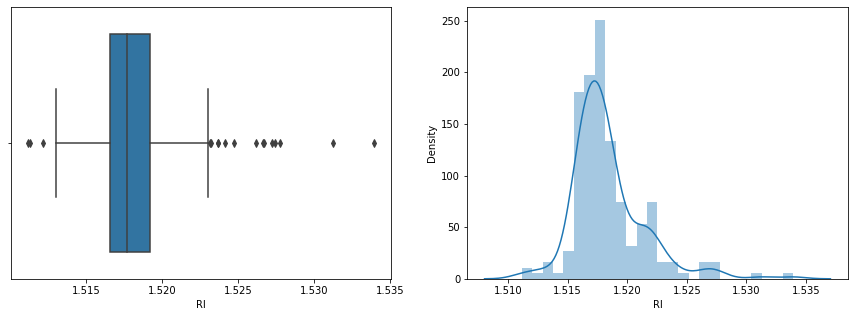

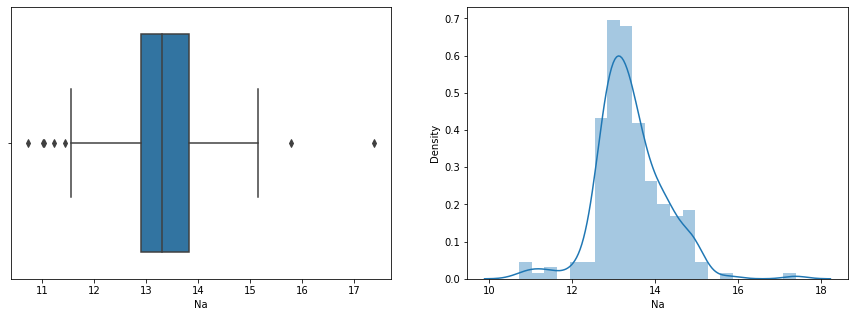

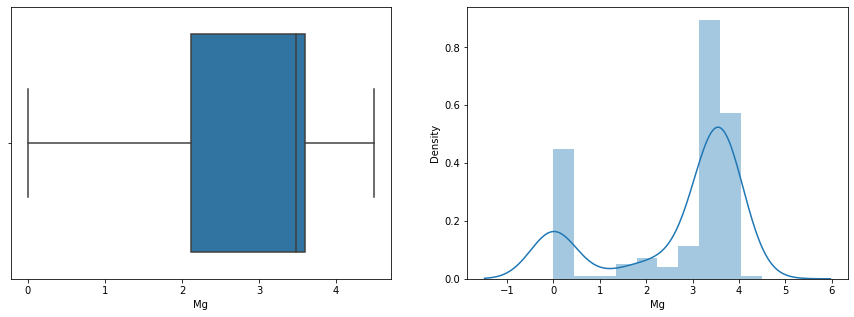

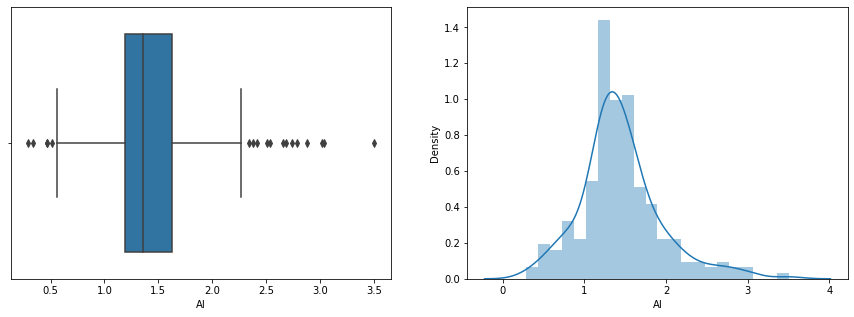

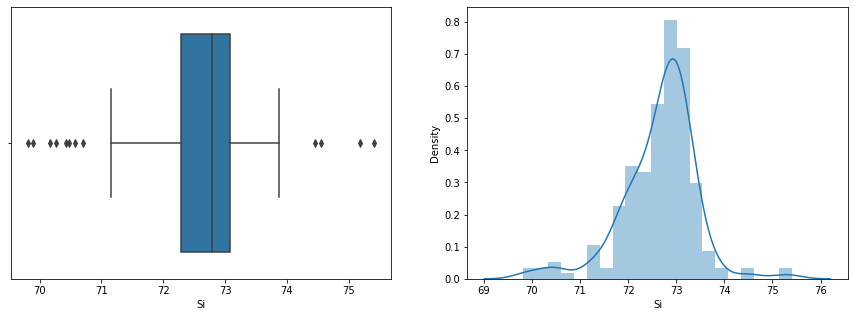

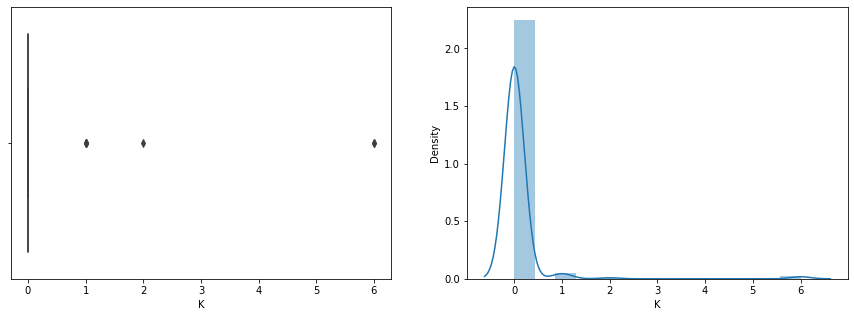

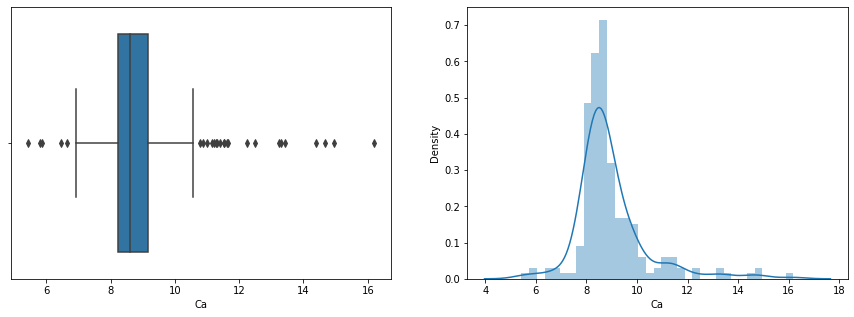

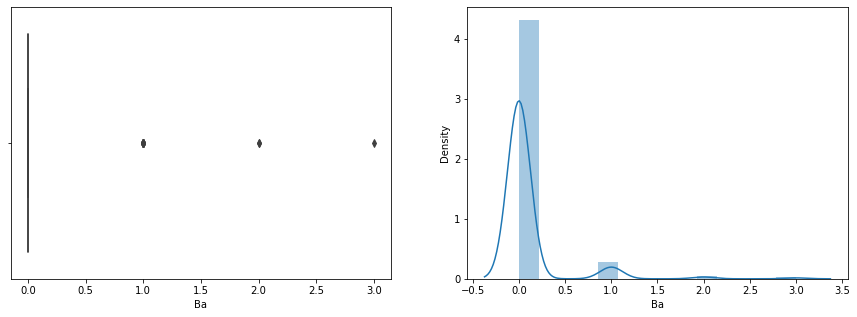

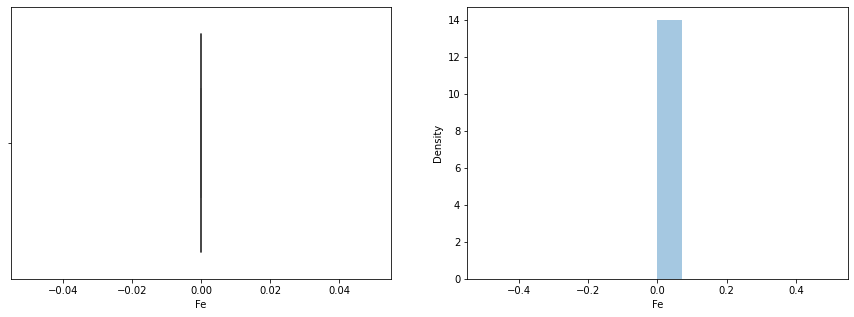

In [185]:
for col in df_glass.columns[:-2]:
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  sns.boxplot(x=df_glass[col], ax=ax[0])
  sns.distplot(a=df_glass[col], ax=ax[1])
  plt.show();

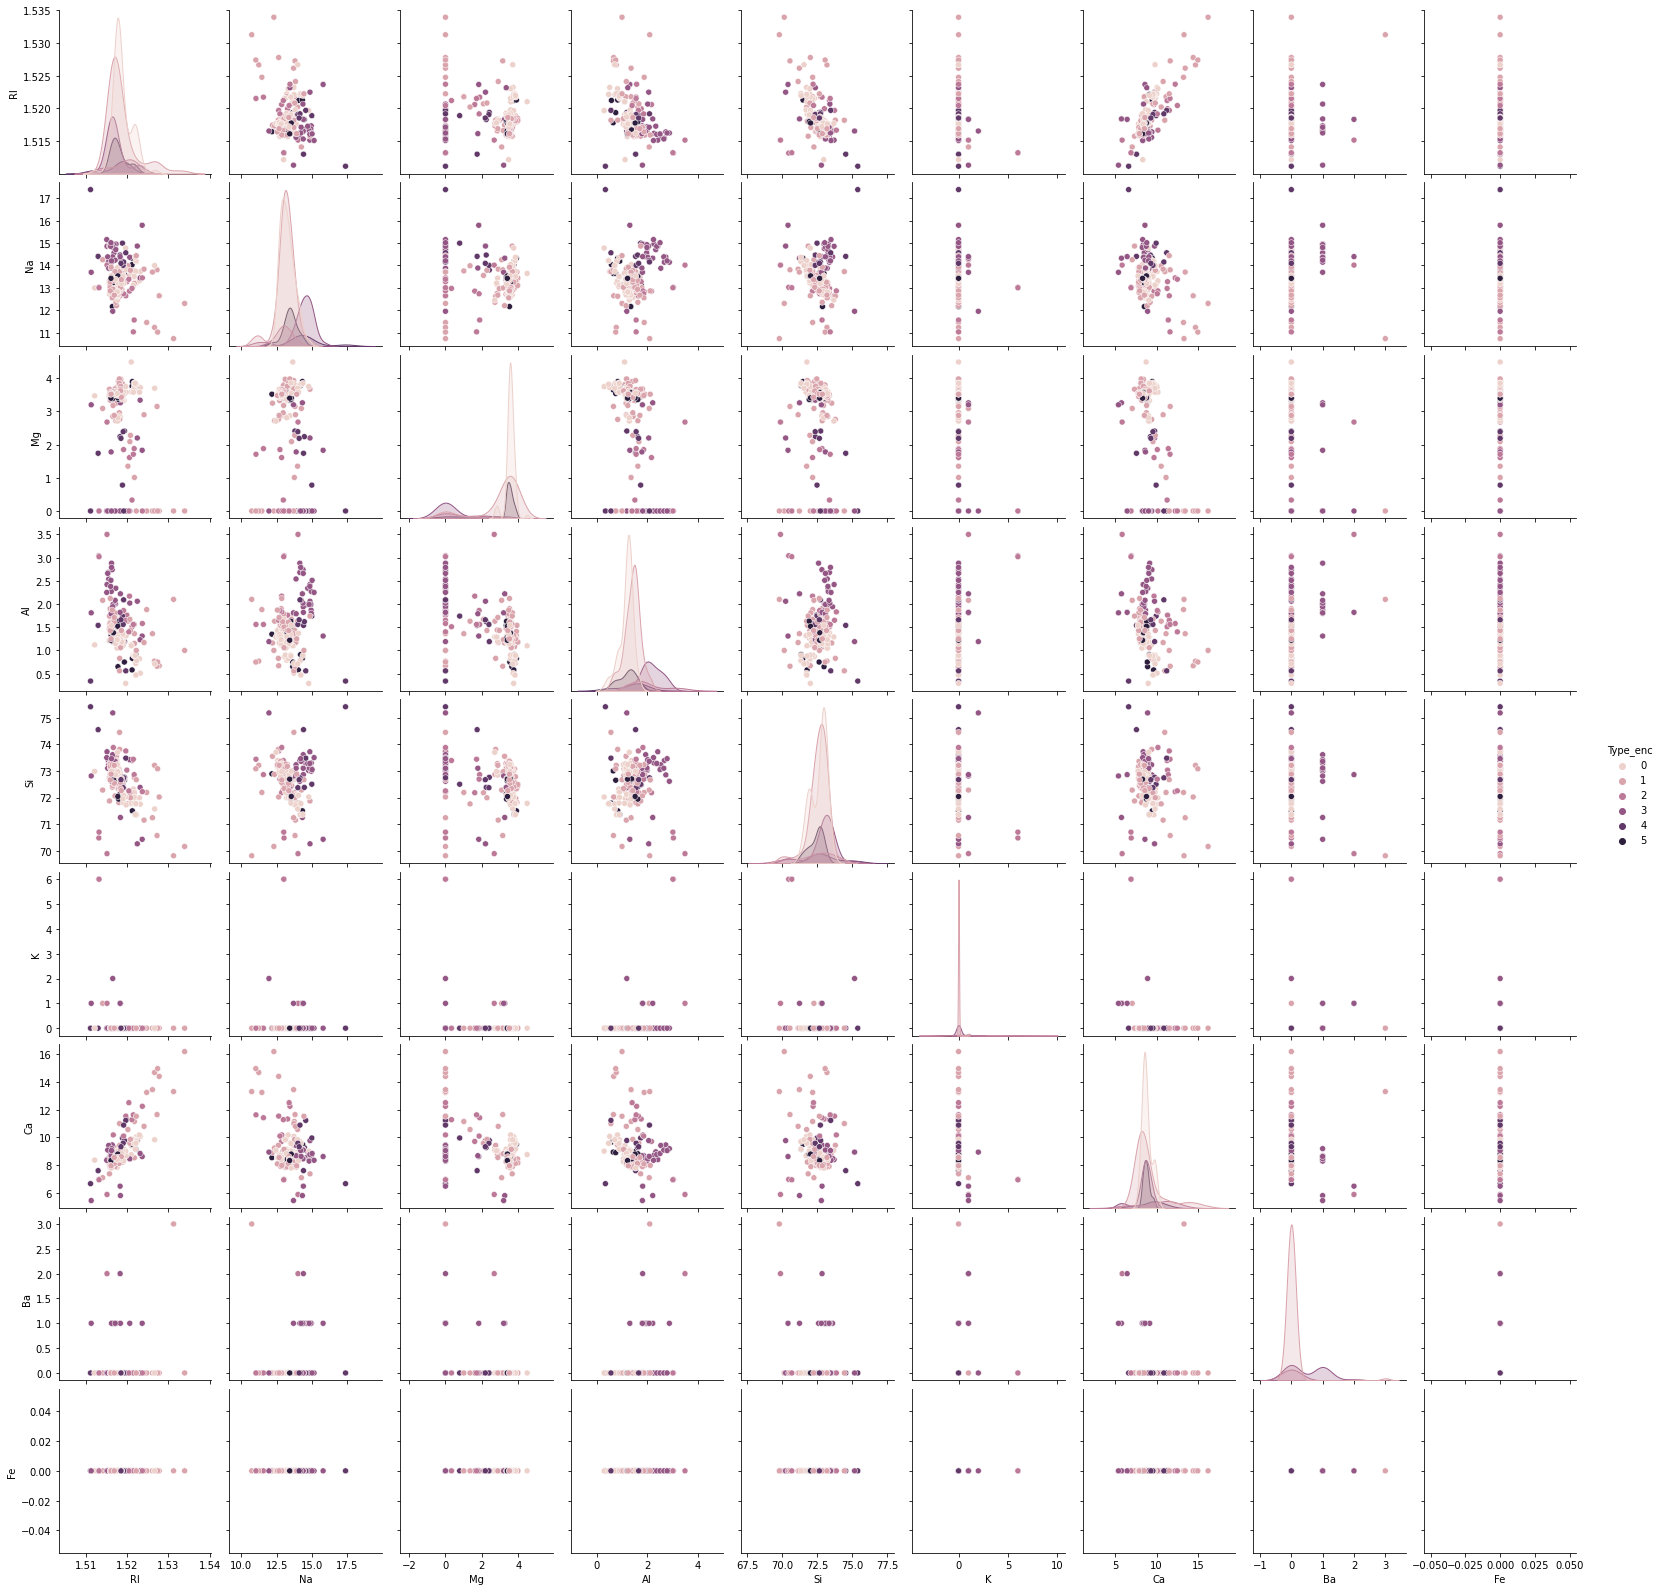

In [186]:
sns.pairplot(df_glass, hue='Type_enc');

#### LOF en pocas dimensiones

In [187]:
df_sub = df_glass[['Na', 'Mg', 'Ca']]

In [188]:
import plotly.express as px

fig = px.scatter_3d(df_glass, x='Na', y='Mg', z='Ca', 
                    color='Type_enc', symbol='Type_enc')
fig.show()

In [189]:
x = df_sub.Na.to_numpy()
y = df_sub.Mg.to_numpy()
# z = df_sub.Ca.to_numpy()

In [190]:
lof = LocalOutlierFactor(n_neighbors=20)
y_pred = lof.fit_predict(df_sub)
X_scores = lof.negative_outlier_factor_
outliers = y_pred == -1

In [191]:
print('Number of outliers detected by LOF:', 
outliers[outliers==True].shape[0])

Number of outliers detected by LOF: 37


In [192]:
round_values = np.around(X_scores, decimals=2)
new = round_values*(-1)

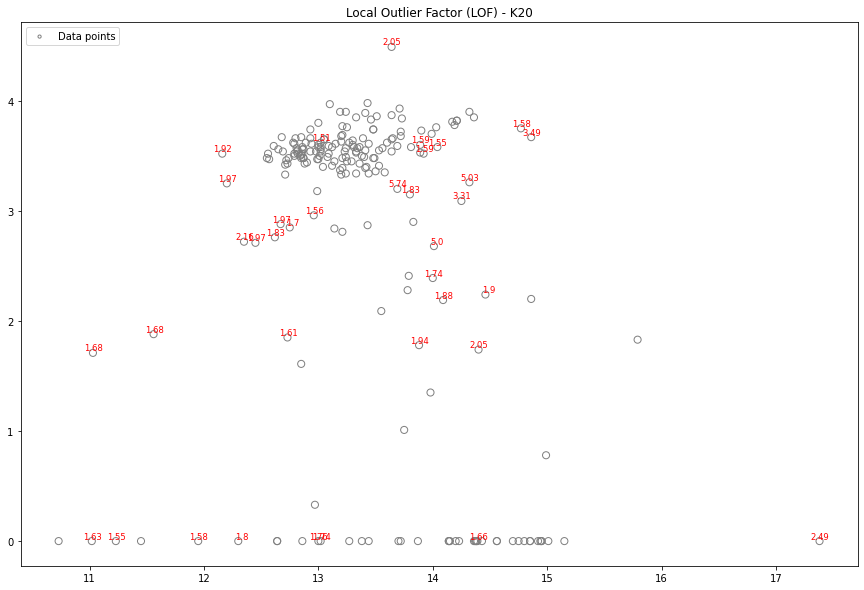

In [193]:
plt.figure(figsize=(15, 10))
plt.title("Local Outlier Factor (LOF) - K20")
plt.scatter(x, y, edgecolor='grey', s=50, label='Data points', facecolors='none')
for x_pos, y_pos, label in zip(x, y, new):
    if label > 1.5:
        plt.annotate(label,             
                xy=(x_pos, y_pos),
                xytext=(10,5),     
                textcoords='offset points', 
                ha='right',         
                va='center', fontsize=8.5, 
                color='r')
plt.axis('tight')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
plt.show()

In [194]:
lof = LocalOutlierFactor(n_neighbors=10)
y_pred = lof.fit_predict(df_sub)
X_scores = lof.negative_outlier_factor_
round_values = np.around(X_scores, decimals=2)
new = round_values*(-1)

In [195]:
outliers = y_pred == -1
print('Number of outliers detected by LOF:', 
outliers[outliers==True].shape[0])

Number of outliers detected by LOF: 31


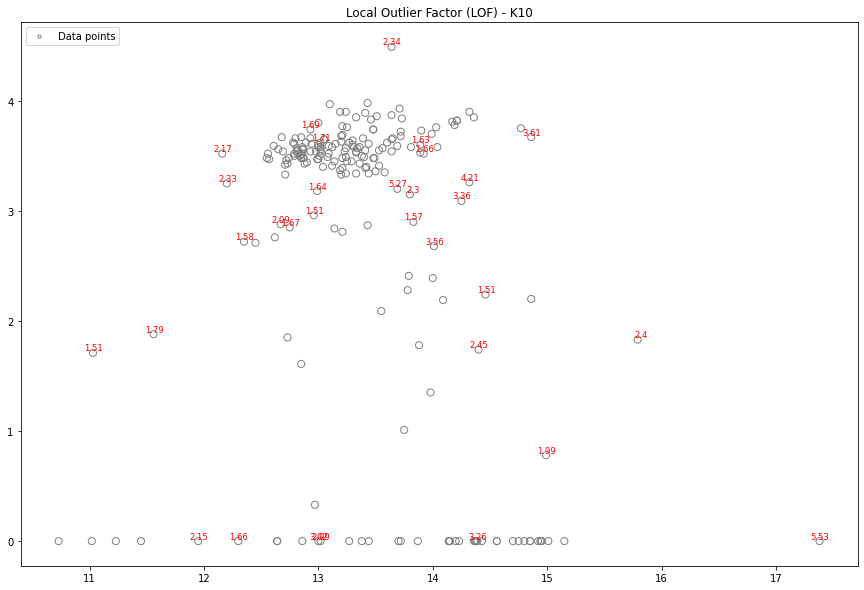

In [196]:
plt.figure(figsize=(15, 10))
plt.title("Local Outlier Factor (LOF) - K10")
plt.scatter(x, y, edgecolor='grey', s=50, label='Data points', facecolors='none')
for x_pos, y_pos, label in zip(x, y, new):
    if label > 1.5:
        plt.annotate(label,             
                xy=(x_pos, y_pos),
                xytext=(10,5),     
                textcoords='offset points', 
                ha='right',         
                va='center', fontsize=8.5, 
                color='r')
plt.axis('tight')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
plt.show()

In [197]:
lof = LocalOutlierFactor(n_neighbors=60)
y_pred = lof.fit_predict(df_sub)
X_scores = lof.negative_outlier_factor_
round_values = np.around(X_scores, decimals=2)
new = round_values*(-1)

In [198]:
outliers = y_pred == -1
print('Number of outliers detected by LOF:', 
outliers[outliers==True].shape[0])

Number of outliers detected by LOF: 85


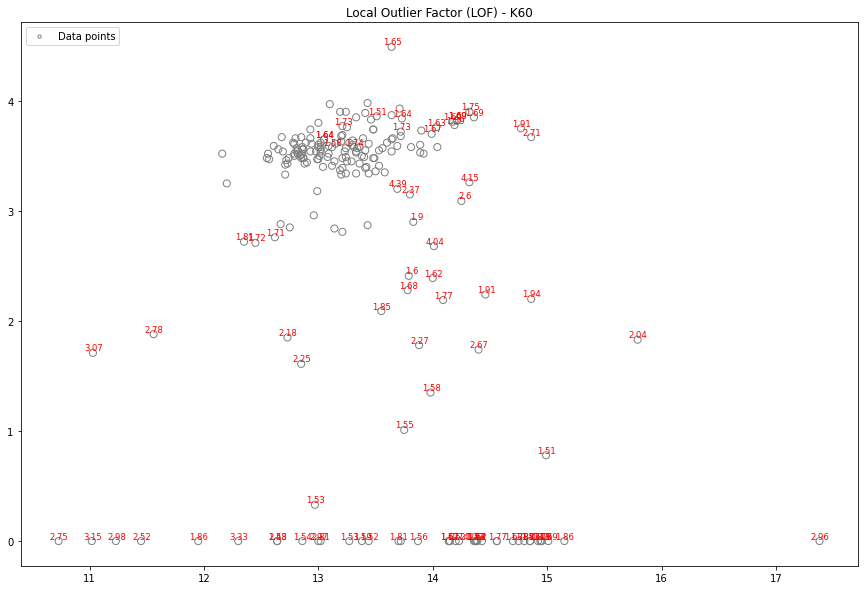

In [199]:
plt.figure(figsize=(15, 10))
plt.title("Local Outlier Factor (LOF) - K60")
plt.scatter(x, y, edgecolor='grey', s=50, label='Data points', facecolors='none')
for x_pos, y_pos, label in zip(x, y, new):
    if label > 1.5:
        plt.annotate(label,             
                xy=(x_pos, y_pos),
                xytext=(10,5),     
                textcoords='offset points', 
                ha='right',         
                va='center', fontsize=8.5, 
                color='r')
plt.axis('tight')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
plt.show()

Number of outliers detected by LOF: 37


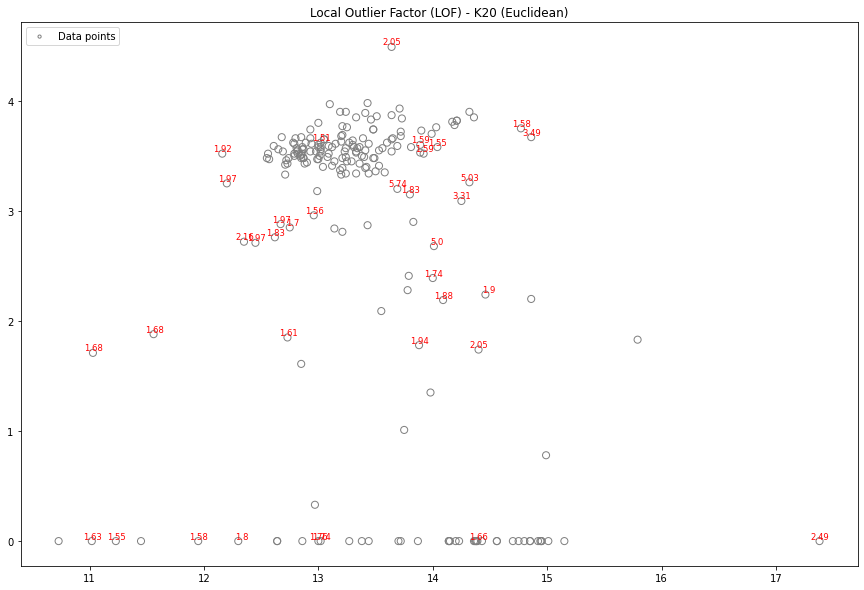

In [200]:
lof = LocalOutlierFactor(n_neighbors=20, metric='euclidean')
y_pred = lof.fit_predict(df_sub)
X_scores = lof.negative_outlier_factor_
round_values = np.around(X_scores, decimals=2)
new = round_values*(-1)

outliers = y_pred == -1
print('Number of outliers detected by LOF:', 
outliers[outliers==True].shape[0])

plt.figure(figsize=(15, 10))
plt.title("Local Outlier Factor (LOF) - K20 (Euclidean)")
plt.scatter(x, y, edgecolor='grey', s=50, label='Data points', facecolors='none')
for x_pos, y_pos, label in zip(x, y, new):
    if label > 1.5:
        plt.annotate(label,             
                xy=(x_pos, y_pos),
                xytext=(10,5),     
                textcoords='offset points', 
                ha='right',         
                va='center', fontsize=8.5, 
                color='r')
plt.axis('tight')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
plt.show()

#### LOF con todas las dimensiones

In [201]:
df_glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type,Type_enc
0,1.518,12.790,3.500,1.120,73.030,0.000,8.770,0.000,0.000,b'build wind float',0
1,1.516,12.160,3.520,1.350,72.890,0.000,8.530,0.000,0.000,b'vehic wind float',5
2,1.518,13.210,3.480,1.410,72.640,0.000,8.430,0.000,0.000,b'build wind float',0
3,1.513,14.400,1.740,1.540,74.550,0.000,7.590,0.000,0.000,b'tableware',4
4,1.534,12.300,0.000,1.000,70.160,0.000,16.190,0.000,0.000,b'build wind non-float',1


In [206]:
X = df_glass.drop(columns=['Type', 'Type_enc'])
y = df_glass.Type_enc

lof = LocalOutlierFactor()
y_pred = lof.fit_predict(X, y)

In [207]:
outliers = y_pred == -1
print('Number of outliers detected by LOF:', 
outliers[outliers==True].shape[0])


Number of outliers detected by LOF: 37


In [208]:
X_outliers, y_outliers = X[outliers], y[outliers]

In [210]:
X_outliers.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
1,1.516,12.160,3.520,1.350,72.890,0.000,8.530,0.000,0.000
3,1.513,14.400,1.740,1.540,74.550,0.000,7.590,0.000,0.000
4,1.534,12.300,0.000,1.000,70.160,0.000,16.190,0.000,0.000
5,1.517,12.750,2.850,1.440,73.270,0.000,8.790,0.000,0.000
6,1.518,13.640,3.650,0.650,73.000,0.000,8.930,0.000,0.000


In [211]:
X_outliers.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,37.000,37.000,37.000,37.000,37.000,37.000,37.000,37.000,37.000
mean,1.519,13.322,2.026,1.607,72.442,0.514,9.135,0.270,0.000
std,0.005,1.344,1.210,0.654,1.396,1.407,2.303,0.693,0.000
min,1.511,10.730,0.000,0.340,69.810,0.000,5.430,0.000,0.000
25%,1.516,12.450,1.710,1.280,71.870,0.000,7.590,0.000,0.000
50%,1.518,13.210,2.240,1.560,72.810,0.000,9.020,0.000,0.000
75%,1.521,14.090,2.850,1.820,73.100,0.000,9.700,0.000,0.000
max,1.534,17.380,3.670,3.500,75.410,6.000,16.190,3.000,0.000
